In [1]:
import cv2
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from sklearn.model_selection import train_test_split
from keras import layers, Input, models, optimizers
from keras.models import Model, Sequential
from keras.layers import MaxPooling2D, Conv2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras_preprocessing import image

Using TensorFlow backend.


VGG16 호출

In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet',
                 include_top=False,
                 input_shape=(150,150,3))

train/ validation / test 디렉토리 설정

In [3]:
base_dir = './train_upper_base/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

특성 추출

In [4]:
def extract_features(directory,sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count,4))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [5]:
train_sampel = 1290

train_features, train_labels = extract_features(train_dir, train_sampel) #5096

Found 1290 images belonging to 4 classes.


In [6]:
validation_sample = 645

validation_features, validation_labels = extract_features(validation_dir, validation_sample) # 2548

Found 645 images belonging to 4 classes.


In [7]:
test_sample = 645

test_features, test_labels = extract_features(test_dir, test_sample) #2547

Found 645 images belonging to 4 classes.


In [8]:
train_features = np.reshape(train_features,(train_sampel, 4 * 4 * 512))
validation_features = np.reshape(validation_features,(validation_sample, 4 * 4 * 512))
test_features = np.reshape(test_features,(test_sample, 4 * 4 * 512))

학습

In [9]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('best_model_pattern_0424.h5', monitor='val_loss', mode='min', save_best_only=True)

In [10]:
from keras import models, layers, optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim = 4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))
model.compile(optimizer = optimizers.RMSprop(lr=2e-5),
                         loss='categorical_crossentropy',
                         metrics=['acc'])

In [11]:
history = model.fit(train_features, train_labels,
                   epochs=500,
                   batch_size=20,
                   validation_data=(validation_features, validation_labels),
                   callbacks=[es,mc])

Train on 1290 samples, validate on 645 samples
Epoch 1/500
1290/1290 [==============================] - 2s 1ms/step - loss: 1.4563 - acc: 0.3566 - val_loss: 1.1613 - val_acc: 0.5256
Epoch 2/500
1290/1290 [==============================] - 1s 1ms/step - loss: 1.1337 - acc: 0.5178 - val_loss: 1.0181 - val_acc: 0.6000
Epoch 3/500
1290/1290 [==============================] - 2s 1ms/step - loss: 0.9552 - acc: 0.6202 - val_loss: 0.9354 - val_acc: 0.6186
Epoch 4/500
1290/1290 [==============================] - 2s 1ms/step - loss: 0.8299 - acc: 0.6806 - val_loss: 0.8970 - val_acc: 0.6434
Epoch 5/500
1290/1290 [==============================] - 2s 1ms/step - loss: 0.7320 - acc: 0.7395 - val_loss: 0.8448 - val_acc: 0.6729
Epoch 6/500
1290/1290 [==============================] - 2s 1ms/step - loss: 0.6606 - acc: 0.7674 - val_loss: 0.8080 - val_acc: 0.6853
Epoch 7/500
1290/1290 [==============================] - 2s 1ms/step - loss: 0.5845 - acc: 0.7953 - val_loss: 0.7842 - val_acc: 0.6961
Epoch 8/

Epoch 61/500
1290/1290 [==============================] - 1s 1ms/step - loss: 0.0500 - acc: 0.9907 - val_loss: 0.6274 - val_acc: 0.7721
Epoch 62/500
1290/1290 [==============================] - 2s 1ms/step - loss: 0.0438 - acc: 0.9961 - val_loss: 0.6279 - val_acc: 0.7736
Epoch 63/500
1290/1290 [==============================] - 2s 1ms/step - loss: 0.0445 - acc: 0.9961 - val_loss: 0.6353 - val_acc: 0.7798
Epoch 64/500
1290/1290 [==============================] - 2s 1ms/step - loss: 0.0425 - acc: 0.9961 - val_loss: 0.6243 - val_acc: 0.7814
Epoch 65/500
1290/1290 [==============================] - 2s 1ms/step - loss: 0.0473 - acc: 0.9946 - val_loss: 0.6348 - val_acc: 0.7736
Epoch 66/500
1290/1290 [==============================] - 2s 1ms/step - loss: 0.0380 - acc: 0.9953 - val_loss: 0.6334 - val_acc: 0.7814
Epoch 67/500
1290/1290 [==============================] - 1s 1ms/step - loss: 0.0392 - acc: 0.9961 - val_loss: 0.6422 - val_acc: 0.7705
Epoch 68/500
1290/1290 [========================

모델 저장

In [14]:
model.save('upper_9978.h5')

정확도 / 손실 그래프

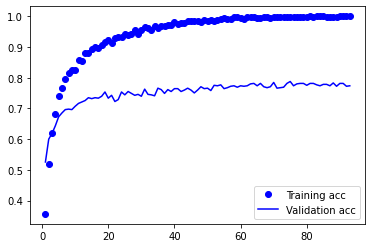

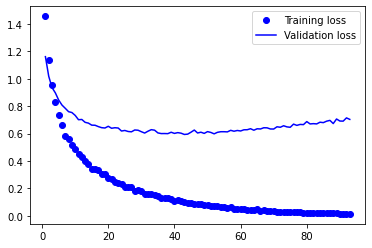

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
# plt.tilte('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
# plt.tilte('Training and validation loss')
plt.legend()

plt.show()